In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
sys.path.append('../')

import os
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2

import numpy as np
import pandas as pd
from operator import itemgetter
import matplotlib.pyplot as plt

from src.utils import read_shapefile
from sklearn.model_selection import train_test_split
from config import *

from glob import glob
from config import interim_data_dir

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from IPython.display import clear_output

print(tf.__version__)

1.14.0


In [3]:
def normalize_img(img, max_val=1, min_val=0):
    img_max = np.max(img)
    img_min = np.min(img)
    img_std = (img - img_min) / (img_max - img_min)
    return img_std * (max_val - min_val) + min_val

def zero_pad_mask(img, shape):
    """
    TODO: Parameterize anchoring
    
    :param img:
    :param shape:
    :return:
    """
    
    # If the image has width > max width, crop to max width
    if img.shape[0] > shape[0]:
        img = img[:shape[0],:]
    
    # If the image has height > max height, crop to max height
    if img.shape[1] > shape[1]:
        img = img[:, :shape[1]]
    
    # Size of border
    v_border = int(np.ceil((shape[0] - img.shape[0]) / 2))
    h_border = int(np.ceil((shape[1] - img.shape[1]) / 2))

    v_diff = shape[0] - (img.shape[0] + 2 * v_border)
    h_diff = shape[1] - (img.shape[1] + 2 * h_border)

    new_img = cv2.copyMakeBorder(
        img,
        top=v_border, bottom=v_border + v_diff,
        left=h_border, right=h_border + h_diff,
        borderType=cv2.BORDER_CONSTANT, 
        value=0
    )

    assert new_img.shape == shape, 'zero padding issue'

    return new_img

def process_img(img,shape):
    return zero_pad_mask(normalize_img(img), shape=shape)

def process_data(images,max_dims, ids, labels=None):
    
    #data = np.array(list(map(lambda a: process_img(shape = (max_dims,max_dims)), images))).reshape(-1, (max_dims,max_dims), 1)
    #data = np.array(list(map(process_img, images, [max_dims,max_dims] ))).reshape(-1, (max_dims,max_dims), 1)
    data = np.array(list([process_img(img = a, shape = (max_dims,max_dims)) for a in images]))
    data = np.expand_dims(data, axis=-1)
    
    # Remove nans
    nan_idxs = [i for i, img in enumerate(data) if np.isnan(img).any()]
    
    print('Removing {} farms'.format(len(nan_idxs)))

    data = np.delete(data, nan_idxs, axis=0)
    nan_ids = np.array(ids)[nan_idxs]
    
    ids = list(np.delete(ids, nan_idxs))

    if labels is not None:
        labels = np.delete(labels, nan_idxs)
    
    return data, labels, ids, nan_ids

def check_for_nans(data):
    for i,arr in enumerate(data):
        if np.isnan(arr).any():
            raise ValueError(f'NaN found at index {i}')
            
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show(); 
        
def get_model(max_dims):
    MAX_DIMS = (28, 28)
    
    model = models.Sequential()
    model.add(layers.Conv2D(8, (4, 4), activation='relu', input_shape=(*MAX_DIMS, 1)))
    model.add(layers.MaxPooling2D((4, 4)))
    model.add(layers.Conv2D(16, (2, 2), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(layers.Dense(9, activation='softmax'))
    
    return model
    
def prepare_date_band_data(date = '2017-01-01',band = 'B05',max_dims = 28):
    
    train_shp_df = read_shapefile('train')
    test_shp_df = read_shapefile('test')

    # Labels must be zero indexed
    train_shp_df['Crop_Id_Ne'] = train_shp_df['Crop_Id_Ne'].astype(int) - 1

    train_ids_list = train_shp_df.index.to_list()
    train_labels = np.array(train_shp_df['Crop_Id_Ne'])

    test_ids_list = test_shp_df.index.to_list()

    # Get list of images filepaths
    train_images = glob(os.path.join(interim_data_dir, 'masks', 'train', date, f'*_{band}.npy'))
    test_images = glob(os.path.join(interim_data_dir, 'masks', 'test', date, f'*_{band}.npy'))

    # Load images
    train_imgs = [np.load(f) for f in train_images]
    test_imgs = [np.load(f) for f in test_images]

    print('There are {} train images loaded'.format(len(train_imgs)))
    print('There are {} test images loaded'.format(len(test_imgs)))

    print('Processing training...')
    
    train_data, train_labels, train_ids_list, train_nan_ids = process_data(train_imgs,max_dims, train_ids_list, train_labels)

    print('Processing testing...')
    test_data, test_labels, test_ids_list, test_nan_ids = process_data(test_imgs,max_dims, test_ids_list)

    check_for_nans(train_data)
    check_for_nans(test_data)

    print('Train data:\t\t', train_data.shape)
    print('Test data:\t\t',test_data.shape)
    
    sets = {"train_data":train_data, "train_labels":train_labels,"train_ids_list":train_ids_list,"test_data":test_data,"test_labels":test_labels,"test_ids_list":test_ids_list}
    
    return(sets)


In [4]:
max_dims = 28
date = '2017-01-01'
band = 'B05'

sets_single_band_time = prepare_date_band_data(date = date,band = band, max_dims = max_dims)

train_data, val_data, train_labels, val_labels = train_test_split(sets_single_band_time['train_data'], sets_single_band_time['train_labels'], test_size=0.3, stratify=sets_single_band_time['train_labels'], random_state=420)

enc = OneHotEncoder(sparse=False, categories='auto')

train_labels_enc = enc.fit_transform(train_labels.reshape(-1,1))
val_labels_enc = enc.transform(val_labels.reshape(-1,1))

There are 2494 train images loaded
There are 1074 test images loaded
Processing training...


AssertionError: zero padding issue

In [25]:
model = get_model(max_dims)
plot_losses = PlotLosses()

es = EarlyStopping(monitor='val_loss', verbose=1,patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model.compile(optimizer='adam',
              loss=keras.metrics.sparse_categorical_crossentropy,
              #loss=keras.metrics.categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

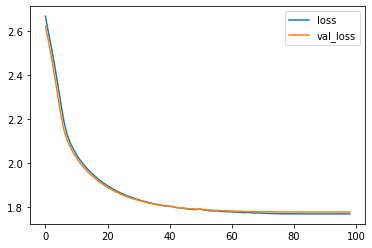

1743/1743 - 0s - loss: 1.7700 - sparse_categorical_crossentropy: 1.7530 - val_loss: 1.7786 - val_sparse_categorical_crossentropy: 1.7616
Epoch 00099: early stopping


In [26]:
%matplotlib inline
from IPython.display import clear_output

model.fit(train_data, 
          train_labels,
          batch_size=256,
          validation_data=(val_data, val_labels), 
          verbose=2,
          epochs=100,
          callbacks=[plot_losses,es,reduce_lr])

We can try to measure this on a different date and band?

In [41]:
max_dims = 28
date = '2017-01-01'
band = 'B01'

sets_single_band_time = prepare_date_band_data(date = date,band = band, max_dims = max_dims)

train_data, val_data, train_labels, val_labels = train_test_split(sets_single_band_time['train_data'], sets_single_band_time['train_labels'], test_size=0.3, stratify=sets_single_band_time['train_labels'], random_state=420)

enc = OneHotEncoder(sparse=False, categories='auto')

train_labels_enc = enc.fit_transform(train_labels.reshape(-1,1))
val_labels_enc = enc.transform(val_labels.reshape(-1,1))

There are 2494 train images loaded
There are 1074 test images loaded
Processing training...
Removing 128 farms
Processing testing...
Removing 855 farms
Train data:		 (2366, 28, 28, 1)
Test data:		 (219, 28, 28, 1)


/opt/conda/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


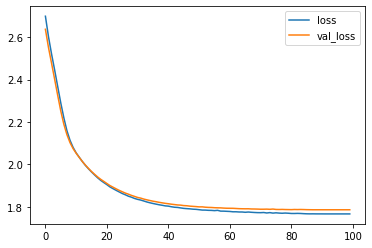


Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
1656/1656 - 0s - loss: 1.7672 - sparse_categorical_crossentropy: 1.7544 - val_loss: 1.7868 - val_sparse_categorical_crossentropy: 1.7740


In [42]:
model = get_model(max_dims)
plot_losses = PlotLosses()

es = EarlyStopping(monitor='val_loss', verbose=1,patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model.compile(optimizer='adam',
              loss=keras.metrics.sparse_categorical_crossentropy,
              #loss=keras.metrics.categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.fit(train_data, 
          train_labels,
          batch_size=256,
          validation_data=(val_data, val_labels), 
          verbose=2,
          epochs=100,
          callbacks=[plot_losses,es,reduce_lr])

Quite similar overall it seems, but we are not measuring the confusion matrix, just log loss so class accuracy may vary...

Trying a different date

In [43]:
max_dims = 28
date = '2017-08-04'
band = 'B01'

sets_single_band_time = prepare_date_band_data(date = date,band = band, max_dims = max_dims)

train_data, val_data, train_labels, val_labels = train_test_split(sets_single_band_time['train_data'], sets_single_band_time['train_labels'], test_size=0.3, stratify=sets_single_band_time['train_labels'], random_state=420)

enc = OneHotEncoder(sparse=False, categories='auto')

train_labels_enc = enc.fit_transform(train_labels.reshape(-1,1))
val_labels_enc = enc.transform(val_labels.reshape(-1,1))

There are 2494 train images loaded
There are 1074 test images loaded
Processing training...
Removing 128 farms
Processing testing...
Removing 855 farms
Train data:		 (2366, 28, 28, 1)
Test data:		 (219, 28, 28, 1)


/opt/conda/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


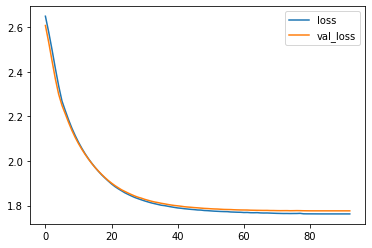


Epoch 00093: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
1656/1656 - 0s - loss: 1.7622 - sparse_categorical_crossentropy: 1.7545 - val_loss: 1.7761 - val_sparse_categorical_crossentropy: 1.7683
Epoch 00093: early stopping


In [47]:
model = get_model(max_dims)
plot_losses = PlotLosses()

es = EarlyStopping(monitor='val_loss', verbose=1,patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

model.compile(optimizer='adam',
              loss=keras.metrics.sparse_categorical_crossentropy,
              #loss=keras.metrics.categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

history = model.fit(train_data, 
          train_labels,
          batch_size=256,
          validation_data=(val_data, val_labels), 
          verbose=2,
          epochs=100,
          callbacks=[plot_losses,es,reduce_lr])

In [50]:
print(min(history.history['val_loss']))

1.7760677398090632


## Using original images instead of masks?

## Multiple bands

The invoke commands had a command for stacking masks, let's have a quick look at these images.

In [35]:
max_dims = 28
resolution = 10
date = 1

# Get list of images filepaths
train_images = glob(os.path.join(processed_data_dir, 'stacked_images','res_{}'.format(resolution), 'train', str(date), '*.npy'))

# Load images
train_imgs = [np.load(f) for f in train_images]


In [36]:
len(train_imgs)

142

Only 142 images?

In [37]:
train_imgs[0].shape

(90, 90, 4)

So these are clearly stacked for 4? channels

But we know that there are actually 12 bands from the interim produced np arrays...

Let's check the higher resolution groups?

In [39]:
max_dims = 28
resolution = 60
date = 1

# Get list of images filepaths
train_images = glob(os.path.join(processed_data_dir, 'stacked_images','res_{}'.format(resolution), 'train', str(date), '*.npy'))

# Load images
train_imgs = [np.load(f) for f in train_images]

print(len(train_imgs))
print(train_imgs[0].shape)

142
(20, 20, 3)


Now it's 3 channels!

In [40]:
max_dims = 28
resolution = 20
date = 1

# Get list of images filepaths
train_images = glob(os.path.join(processed_data_dir, 'stacked_images','res_{}'.format(resolution), 'train', str(date), '*.npy'))

# Load images
train_imgs = [np.load(f) for f in train_images]

print(len(train_imgs))
print(train_imgs[0].shape)

142
(50, 50, 6)


6!

We'll need to figure that out later...
I'm guessing it has to do with the max size cropping or something?

Despite that this may not be such a brick wall. We have an array for each label so we just need to have different encoder heads for each resolution and stack them in a dag if we want to use this data...

On the other hand it may be easier to stack the bands myself with a fixed max_dims crop size such that each

The number of months seems off and the number of images per resolution... I don't have much faith in this data, going back to previous data.

### We could also try to repeat the original pipeline for each band

Firstly, let's look at the actual arrays from the initial run;

In [18]:
list(sets_single_band_time)

['train_data', 'train_labels', 'test_data', 'test_labels']

In [14]:
sets_single_band_time['train_data'].shape

(2490, 28, 28, 1)

Currently the pipeline runs creating the labels together with the arrays for each band. This isn't strictly required but let's just ignore that for now and stack them in a list;

In [66]:
max_dims = 28

bands = ['B01','B02','B03','B04','B05','B06','B07','B8A','B09','B10','B11','B12','TCI']
dates = ['2017-01-01','2017-02-10','2017-03-22','2017-06-20','2017-07-15','2017-08-19','2017-01-31','2017-03-12','2017-05-31','2017-07-10','2017-08-04']

training_dates = {'date':[],'training_data':[]}

for date in dates:
    training_data = {'band':[],'train':[],'labels':[],'shape':[]}
    for band in bands:
        
        
        training_data['band'].append(band)
        
        sets_single_band_time = prepare_date_band_data(date = date,band = band, max_dims = max_dims)

        training_data['train'].append(sets_single_band_time['train_data'])
        training_data['labels'].append(sets_single_band_time['train_labels'])
        train_labels = sets_single_band_time['train_labels']
        
        print('date {} and band {} has training shape {}'.format(date,band,sets_single_band_time['train_data'].shape))
        training_data['shape'].append(sets_single_band_time['train_data'].shape)
    
    training_dates['date'].append(date)
    training_dates['training_data'].append(training_data)

# enc = OneHotEncoder(sparse=False, categories='auto')

# train_labels_enc = enc.fit_transform(train_labels.reshape(-1,1))
# val_labels_enc = enc.transform(val_labels.reshape(-1,1))

There are 2494 train images loaded
There are 1074 test images loaded
Processing training...
Removing 128 farms
Processing testing...
Removing 855 farms
Train data:		 (2366, 28, 28, 1)
Test data:		 (219, 28, 28, 1)
date 2017-01-01 and band B01 has training shape (2366, 28, 28, 1)


/opt/conda/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


There are 2494 train images loaded
There are 1074 test images loaded
Processing training...
Removing 1 farms
Processing testing...
Removing 70 farms
Train data:		 (2493, 28, 28, 1)
Test data:		 (1004, 28, 28, 1)
date 2017-01-01 and band B02 has training shape (2493, 28, 28, 1)
There are 2494 train images loaded
There are 1074 test images loaded
Processing training...
Removing 1 farms
Processing testing...
Removing 843 farms
Train data:		 (2493, 28, 28, 1)
Test data:		 (231, 28, 28, 1)
date 2017-01-01 and band B03 has training shape (2493, 28, 28, 1)
There are 2494 train images loaded
There are 1074 test images loaded
Processing training...
Removing 1 farms
Processing testing...
Removing 70 farms
Train data:		 (2493, 28, 28, 1)
Test data:		 (1004, 28, 28, 1)
date 2017-01-01 and band B04 has training shape (2493, 28, 28, 1)
There are 2494 train images loaded
There are 1074 test images loaded
Processing training...
Removing 4 farms
Processing testing...
Removing 843 farms
Train data:		 (2

In [82]:
list(sets_single_band_time)

['train_data', 'train_labels', 'test_data', 'test_labels']

In [67]:
list(training_dates)

['date', 'training_data']

In [69]:
len(training_dates['date'])

11

In [73]:
list(map(len,training_dates['training_data']))

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [77]:
list(training_dates.values())

[['2017-01-01',
  '2017-02-10',
  '2017-03-22',
  '2017-06-20',
  '2017-07-15',
  '2017-08-19',
  '2017-01-31',
  '2017-03-12',
  '2017-05-31',
  '2017-07-10',
  '2017-08-04'],
 [{'band': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B8A',
    'B09',
    'B10',
    'B11',
    'B12',
    'TCI'],
   'train': [array([[[[0.],
             [0.],
             [0.],
             ...,
             [0.],
             [0.],
             [0.]],
    
            [[0.],
             [0.],
             [0.],
             ...,
             [0.],
             [0.],
             [0.]],
    
            [[0.],
             [0.],
             [0.],
             ...,
             [0.],
             [0.],
             [0.]],
    
            ...,
    
            [[0.],
             [0.],
             [0.],
             ...,
             [0.],
             [0.],
             [0.]],
    
            [[0.],
             [0.],
             [0.],
             ...,
             

In [81]:
list(map(len,training_dates['training_data'][0]['labels']))

[2366, 2493, 2493, 2493, 2490, 2490, 2490, 2490, 2366, 2367, 2490, 2490, 2493]

In [89]:
training_dates['date']

['2017-01-01',
 '2017-02-10',
 '2017-03-22',
 '2017-06-20',
 '2017-07-15',
 '2017-08-19',
 '2017-01-31',
 '2017-03-12',
 '2017-05-31',
 '2017-07-10',
 '2017-08-04']

In [91]:
for i, date in enumerate(training_dates['date']):
    print(list(map(lambda x: x.shape ,training_dates['training_data'][i]['train'])))


[(2366, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2366, 28, 28, 1), (2367, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2493, 28, 28, 1)]
[(2366, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2366, 28, 28, 1), (2368, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2493, 28, 28, 1)]
[(2366, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2366, 28, 28, 1), (2367, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2493, 28, 28, 1)]
[(2366, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2493, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2366, 28, 28, 1), (2368, 28, 28, 1), (2490, 28, 28, 1), (2490, 28, 28, 1), (2493, 28, 28, 1)]
[(2366, 